In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.plots as plots

# open database use OpsimDatabase
opsdb = db.OpsimDatabase('baseline2018a.db')
# output
outDir = 'outdir'
resultsDb = db.ResultsDb(outDir=outDir)
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots

import [TDEsMetricTest](https://github.com/xiaolng/maf/blob/master/TDEsMetricTest.py)

In [2]:
#del TDEsMetricTest
from mycode.TDEsMetricTest import TDEsMetricTest

## get skymap 

Finish initializing metric
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Querying database SummaryAllProps with constraint night<900 for columns ['fieldRA', 'fiveSigmaDepth', 'filter', 'fieldDec', 'observationStartMJD']
Found 561259 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<900" constraint now.
monopole: 0.882247  dipole: lon: -120.359, lat: -24.0318, amp: 0.0920556
Plotting complete.


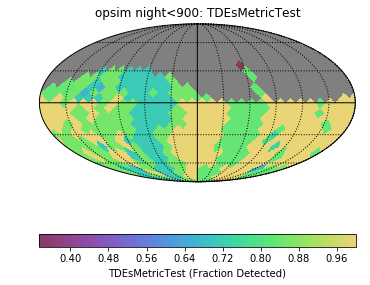

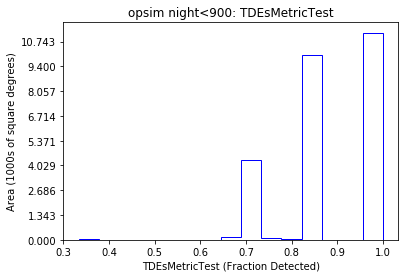

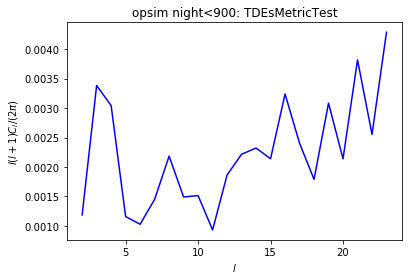

In [3]:
# run the metric
asciifile = 'TDEfaintfast_z0.1.dat'
transmetric = TDEsMetricTest(asciifile=asciifile, metricName='TDEsMetricTest', mjdCol='observationStartMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter', 
                 detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, 
                 peakEpoch=0, nearPeakT=5, 
                 nObsTotal = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}, 
                 nObsPrePeak = 0,
                 nObsNearPeak={'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0},
                 nFiltersNearPeak = 0, 
                 nObsPostPeak=0, nFiltersPostPeak = 0,
                 nPhaseCheck = 1, epochStart = -22, 
                 dataout=False)
                 
slicer = slicers.HealpixSlicer(nside=8) 
sqlconstraint = 'night<900'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

## get light curve

In [4]:
# run the metric
asciifile = 'TDEfaintfast_z0.2.dat'
transmetric = TDEsMetricTest(asciifile=asciifile, metricName='TDEsMetricTest', mjdCol='observationStartMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter', 
                 detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, 
                 peakEpoch=0, nearPeakT=5, 
                 nObsTotal = {'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}, 
                 nObsPrePeak = 0,
                 nObsNearPeak={'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0},
                 nFiltersNearPeak = 0, 
                 nObsPostPeak=0, nFiltersPostPeak=0, 
                 nPhaseCheck = 3, epochStart = -22, 
                 dataout=True)

#slicer = slicers.HealpixSlicer(nside=8)
ra = np.array([34.39339593])
dec = np.array([-5.09032894])
slicer = slicers.UserPointsSlicer(ra, dec)

sqlconstraint = 'night<700'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

Finish initializing metric
Querying database SummaryAllProps with constraint night<700 for columns ['fieldRA', 'fiveSigmaDepth', 'filter', 'fieldDec', 'observationStartMJD']
Found 431650 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<700" constraint now.
Plotting complete.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:517: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')


In [5]:
output_dict_list = transmetricSky.metricValues.data[0]
df = pd.DataFrame(output_dict_list[0])

# pd.set_option('display.max_rows', 2000) # set max number of rows to display
df.head()

,detected,expMJD,filters,lcAboveThresh,lcEpoch,lcMags,lcMagsStd,lcNumber,lcSNR,m5,tshift
0,True,59853.282894,i,False,-22.000000,31.096667,5.733125,0.0,0.005116,23.621657,0.0
1,True,59853.296551,i,False,-21.986343,31.087562,5.834411,0.0,0.004659,23.510772,0.0
2,True,59854.272384,y,False,-21.010509,30.986656,6.842540,0.0,0.001836,22.398682,0.0
3,True,59857.266632,z,False,-18.016262,28.949079,4.151598,0.0,0.022333,23.074038,0.0
4,True,59857.277535,z,False,-18.005359,28.942992,4.117412,0.0,0.023064,23.102912,0.0


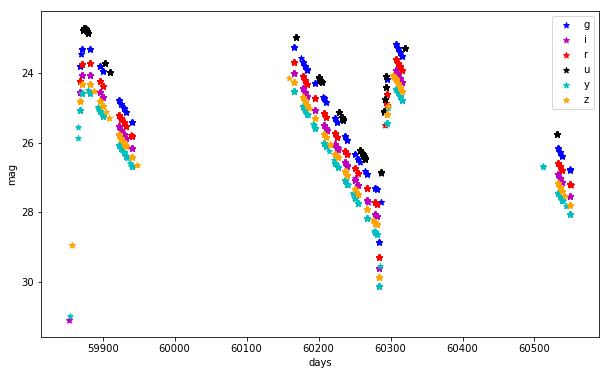

In [6]:
def plotlc(dataSlice, time_key='time', mag_key='mag', filter_key='filter'):
    colors = {'u':'k', 'g':'b', 'r':'r', 'i':'m', 'z':'orange', 'y':'c'}
    
    plt.figure(figsize=(10, 6))
    for f in np.unique(dataSlice[filter_key]):
        fmatch = dataSlice[filter_key]==f
        time = dataSlice[time_key][fmatch]
        mag = dataSlice[mag_key][fmatch]

        plt.scatter(time, mag, color=colors[f], marker='*', label=f)

    plt.legend()
    plt.xlabel('days')
    plt.ylabel('mag')
    plt.ylim(plt.ylim()[::-1])

plotlc(df, time_key='expMJD', mag_key='lcMags', filter_key='filters')


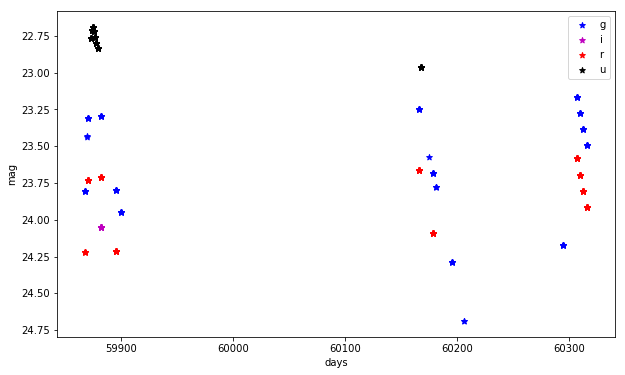

In [19]:
plotlc(df[df['lcAboveThresh']==True], time_key='expMJD', mag_key='lcMags', filter_key='filters')


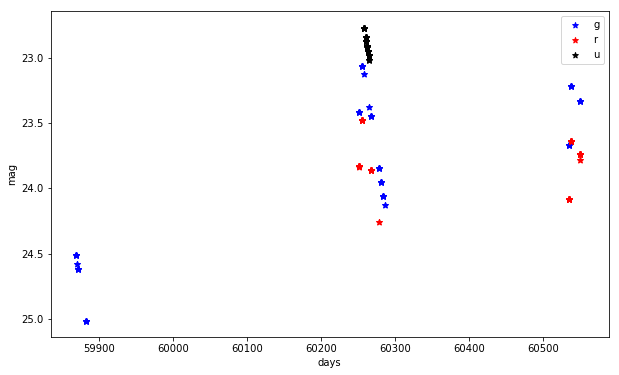

In [17]:
df_1 = pd.DataFrame(output_dict_list[1])

plotlc(df_1[df_1['lcAboveThresh']==True], time_key='expMJD', mag_key='lcMags', filter_key='filters')

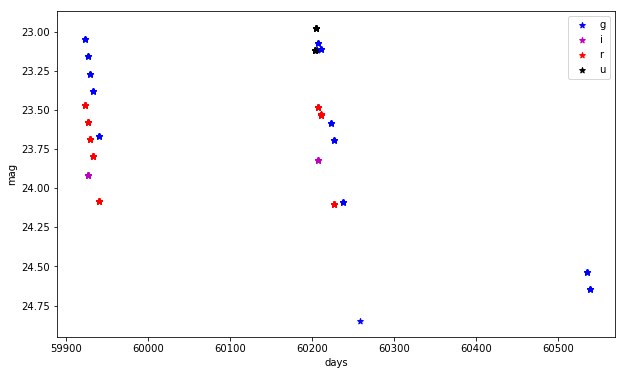

In [18]:
df_2 = pd.DataFrame(output_dict_list[2])

plotlc(df_2[df_2['lcAboveThresh']==True], time_key='expMJD', mag_key='lcMags', filter_key='filters')

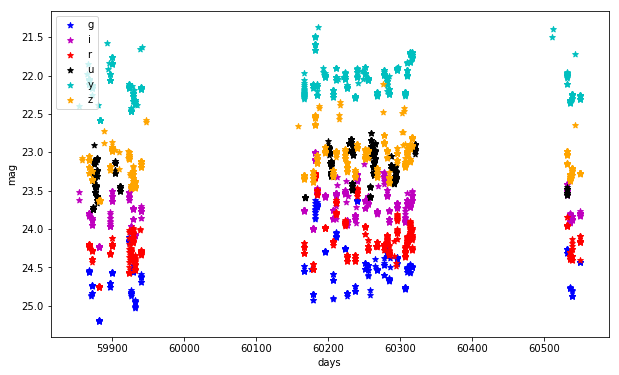

In [16]:
plotlc(df, time_key='expMJD', mag_key='m5', filter_key='filters')

## add some requirements 

Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<700 for columns ['fieldRA', 'fiveSigmaDepth', 'filter', 'fieldDec', 'observationStartMJD']
Found 431650 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<700" constraint now.
monopole: 0.116774  dipole: lon: -94.4172, lat: -6.7904, amp: 0.0360623
Plotting complete.


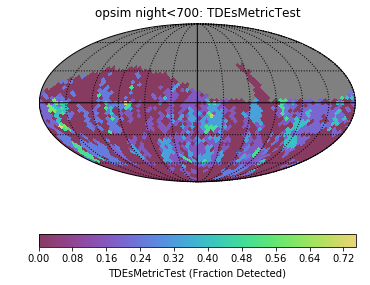

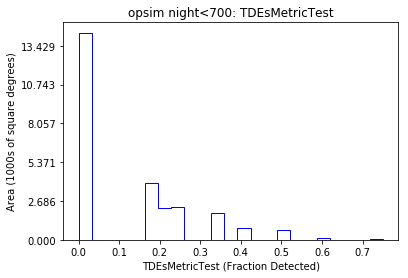

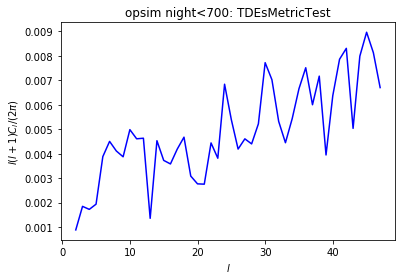

In [21]:
# run the metric
asciifile = 'TDEfaintfast_z0.1.dat'
transmetric = TDEsMetricTest(asciifile=asciifile, metricName='TDEsMetricTest', mjdCol='observationStartMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter', 
                 detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, 
                 peakEpoch=0, nearPeakT=20, 
                 nObsTotal = {'u': 1, 'g': 0, 'r': 1, 'i': 0, 'z': 0, 'y': 0}, 
                 nObsPrePeak = 1,
                 nObsNearPeak={'u': 1, 'g': 0, 'r': 1, 'i': 0, 'z': 0, 'y': 0}, 
                 nObsPostPeak=1,
                 nFiltersNearPeak = 1, 
                 nFiltersPostPeak = 1,
                 nPhaseCheck = 1, epochStart = -22, 
                 dataout=False)
                 
slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<700'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)

In [ ]:

# pd.set_option('display.max_rows', 2000) # set max number of rows to display


Finish initializing metric
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<700 for columns ['fieldRA', 'fiveSigmaDepth', 'filter', 'fieldDec', 'observationStartMJD']
Found 431650 visits
Running:  ['transmetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<700" constraint now.
monopole: 0.575082  dipole: lon: -140.268, lat: -21.792, amp: 0.119458
Plotting complete.


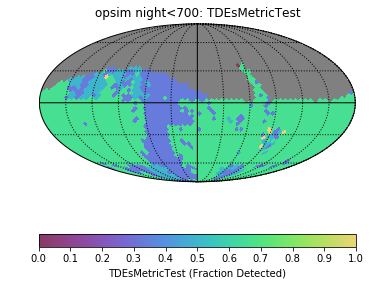

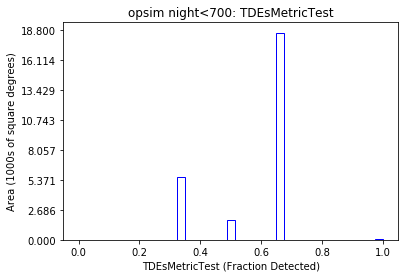

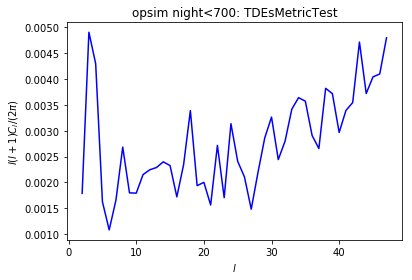

In [27]:
# run the metric
asciifile = 'tde.dat'
transmetric = TDEsMetricTest(asciifile=asciifile, metricName='TDEsMetricTest', mjdCol='observationStartMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter', 
                 detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, 
                 peakEpoch=22, nearPeakT=20, 
                 nObsTotal = {'u': 0, 'g': 0, 'r': 1, 'i': 0, 'z': 0, 'y': 0}, 
                 nObsPrePeak = 0,
                 nObsNearPeak={'u': 0, 'g': 0, 'r': 0, 'i': 0, 'z': 0, 'y': 0}, 
                 nObsPostPeak=0,
                 nFiltersNearPeak = 1, 
                 nFiltersPostPeak = 1,
                 nPhaseCheck = 1, epochStart = 12, 
                 dataout=False)
                 
slicer = slicers.HealpixSlicer(nside=16) 
sqlconstraint = 'night<700'
transmetricSky = metricBundles.MetricBundle(transmetric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'transmetricSky':transmetricSky}, opsdb, outDir=outDir, resultsDb=resultsDb)
group.runAll()
group.plotAll(closefigs=False)